In [457]:
# いろいろインポート
# kerasはTFのラッパー関数
import tensorflow as tf
from tensorflow import keras
from keras import initializers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [458]:
# random seed
# 再現性の担保
import os
import random
os.environ['PYTHONHASHSEED'] = '0'
random.seed(198)
np.random.seed(198)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(198)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [459]:
# データセットの準備　minstの中のfassion_minstを利用。
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Labelが数字だとわかりにくいので決めておく
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 28*28ピクセルの写真が6万枚ある。
print(train_images.shape, "\n")
# i番目の画像をチェックする。
i = 12
plt.figure()
plt.imshow(train_images[i], cmap=plt.cm.binary) # 白黒にする
plt.colorbar()
plt.gca().grid(False)
print(class_names[train_labels[i]])

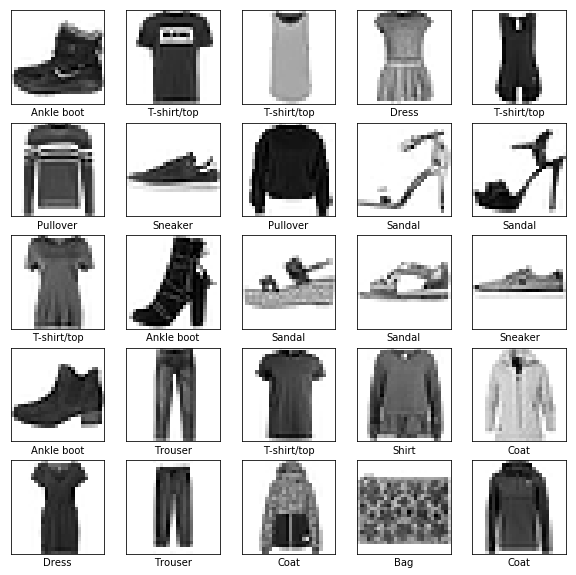

In [474]:
# データの前処理、ピクセル数を[0,1]にする
train_images = train_images / 255.0

test_images = test_images / 255.0

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [482]:
# 各バッチ後の損失、エポック後の損失をゲットするためのクラス
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []
        self.epoch_losses = []
        self.test_losses = []
    def on_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))
    def on_epoch_end(self, batch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.test_losses.append(logs.get("val_loss")) 
        print(len(self.epoch_losses), end="")

In [507]:
# 初期化
h = keras.initializers.he_normal(seed=0)

In [508]:
# 深層モデルの構築
# 入力はピクセル(28*28)を行ベクトル(1*784)にしたもの
# 入力　→ (hidden layers) → ソフトマックス層(出力層)

history_1 = LossHistory()
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(128, activation=tf.nn.relu, kernel_initializer=h))
model.add(keras.layers.Dense(32, activation=tf.nn.relu, kernel_initializer=h))

model.add(keras.layers.Dense(10, activation=tf.nn.softmax, kernel_initializer=h))


# モデルをコンパイルする
model.compile(
              optimizer=tf.keras.optimizers.Adam(lr=0.01), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_images, train_labels, batch_size=4096, epochs=100, \
                 validation_data=(test_images, test_labels), \
                 callbacks=[history_1],verbose=0)

test_loss_1, test_acc_1 = model.evaluate(test_images, test_labels)
predictions_1 = model.predict(test_images)

10000/10000 [==============================] - 1s 103us/sample - loss: 0.3631 - acc: 0.8713515253545556575859606162636465666768697071727374757677787980818283848586878889909


In [509]:
# Early-stopping 
history_2 = LossHistory()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose= 1)

# なぜかわからんがもう一度モデルを定義するところから始める
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(128, activation=tf.nn.relu, kernel_initializer=h))
model.add(keras.layers.Dense(32, activation=tf.nn.relu, kernel_initializer=h))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax, kernel_initializer=h))

# モデルをコンパイルする
model.compile(
              optimizer=tf.keras.optimizers.Adam(lr=0.01), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist_2 = model.fit(train_images, train_labels, batch_size=4096, epochs=100, \
                 validation_data=(test_images, test_labels), \
                 callbacks=[history_2, early_stopping],verbose=0)
test_loss_2, test_acc_2 = model.evaluate(test_images, test_labels)
predictions_2 = model.predict(test_images)

12345678910111213141516171819202122232425262728293031323334Epoch 00034: early stopping
10000/10000 [==============================] - 1s 112us/sample - loss: 0.4516 - acc: 0.8380


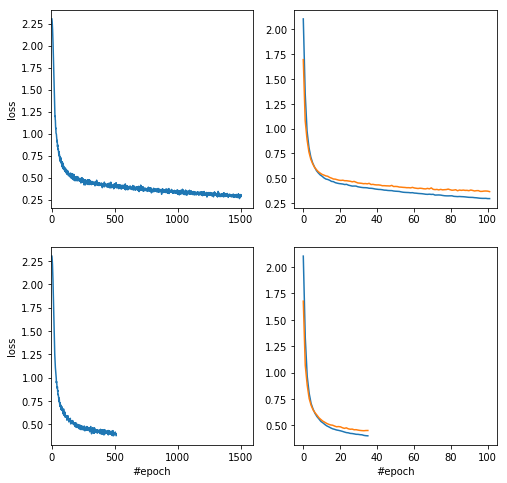

In [512]:
# lossをプロット
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
x_batch = np.linspace(0, len(history_1.batch_losses)+1, len(history_1.batch_losses))
plt.ylabel("loss" )
plt.xlim(-10, 1600)
plt.plot(x_batch, history_1.batch_losses)
plt.subplot(2, 2, 2)
x_test = np.linspace(0, len(history_1.test_losses)+1, len(history_1.test_losses))
plt.xlim(-5, 105)
plt.plot(x_test, history_1.epoch_losses)
plt.plot(x_test, history_1.test_losses)

# Early-stopping 
plt.subplot(2, 2, 3)
x_batch = np.linspace(0, len(history_2.batch_losses)+1, len(history_2.batch_losses))
plt.xlabel("#epoch")
plt.ylabel("loss" )
plt.xlim(-10, 1600)
plt.plot(x_batch, history_2.batch_losses)
plt.subplot(2, 2, 4)
x_test = np.linspace(0, len(history_2.test_losses)+1, len(history_2.test_losses))
plt.xlabel("#epoch")
plt.xlim(-5, 105)
plt.plot(x_test, history_2.epoch_losses)
plt.plot(x_test, history_2.test_losses)
plt.show()

In [514]:
print('Test accuracy full:', test_acc_1, 'Test accuracy early stop:', test_acc_2)

Test accuracy full: 0.8713 Test accuracy early stop: 0.838


In [515]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

NameError: name 'predictions_1' is not defined

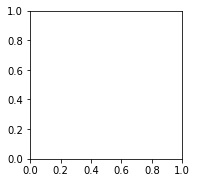

In [516]:
# i番目のテストサンプルの評価
i = 12
plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plot_image(i, predictions_1, test_labels, test_images)
plt.subplot(2,2,2)
plot_value_array(i, predictions_1,  test_labels)
plt.subplot(2,2,3)
plot_image(i, predictions_2, test_labels, test_images)
plt.subplot(2,2,4)
plot_value_array(i, predictions_2,  test_labels)

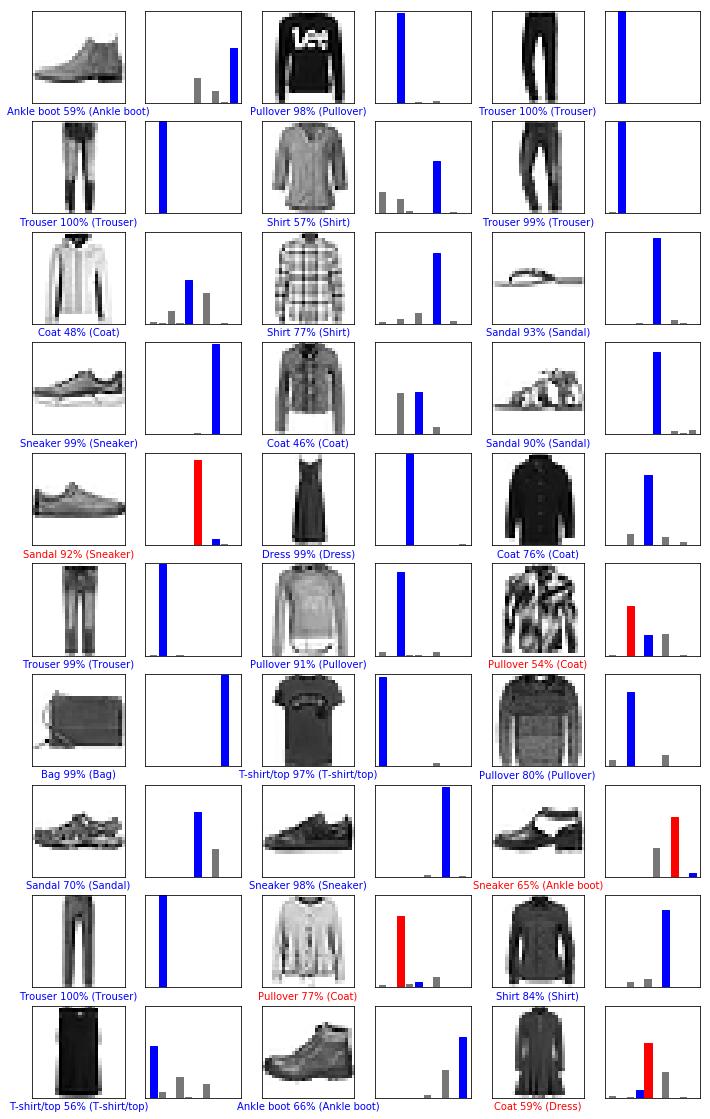

In [452]:
# X個のテスト画像、予測されたラベル、正解ラベルを表示します。
# 正しい予測は青で、間違った予測は赤で表示しています。
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)